In [149]:
import os

def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_dir = "../dataset"
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
raw_text = raw_text.split('\n')
for idx, text in enumerate(raw_text):
    raw_text[idx] = text.split('CC-BY 2.0')[0]

print("总共" + str(len(raw_text)) + "组英语-法语对")
print("前5组英语-法语对示例：")

for i in range(5):
    print(raw_text[i])

raw_text = "\n".join(raw_text[:1000])

总共232737组英语-法语对
前5组英语-法语对示例：
Go.	Va !	
Go.	Marche.	
Go.	En route !	
Go.	Bouge !	
Hi.	Salut !	


In [150]:
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !	
go .	marche .	
go .	en route !	
go .	bouge !	
hi .	salut !	
hi .	salu


In [151]:
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 3:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['go', '.'],
  ['go', '.'],
  ['go', '.'],
  ['hi', '.'],
  ['hi', '.']],
 [['va', '!'],
  ['marche', '.'],
  ['en', 'route', '!'],
  ['bouge', '!'],
  ['salut', '!'],
  ['salut', '.']])

In [152]:
import collections

# 构建字典（词汇表：单词与索引之间的映射）
class Vocab:
    def __init__(self, tokens=None, min_freq=0, reversed_tokens=None):
        if tokens is None:
            tokens = []
        if reversed_tokens is None:
            reversed_tokens = []
        counter = self.count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True) # 词元出现的次数
        self.unk, uniq_tokens = 0, ['<unk>'] + reversed_tokens
        # 去除词频小于min_freq的词
        uniq_tokens += [token for token, freq in self.token_freqs
                        if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], {}
        # 构建词元和数字索引间的映射
        for i in range(len(uniq_tokens)):
            self.idx_to_token.append(uniq_tokens[i])
            self.token_to_idx[uniq_tokens[i]] = i

    # 返回字典的大小
    def __len__(self):
        return len(self.idx_to_token)

    # 获取词元的数字索引
    def __getitem__(self, tokens):
        # tokens 可以是单个单词，也可以是几个单词组成的一段文本
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_token(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[indice] for indice in indices]

    # 统计唯一词元和频率
    def count_corpus(self, tokens):
        if len(tokens) == 0 or isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line] # 取出所有的词元，组成一个一维列表
        return collections.Counter(tokens)

In [153]:
src_vocab = Vocab(source, min_freq=2, reversed_tokens=['<pad>', '<bos>', '<eos>'])
target_vocab = Vocab(target, min_freq=2, reversed_tokens=['<pad>', '<bos>', '<eos>'])
print("源语言字典大小：" + str(len(src_vocab)))
print("目标语言字典大小：" + str(len(target_vocab)))

源语言字典大小：217
目标语言字典大小：279


In [154]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[9, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [155]:
import numpy as np

def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = np.array([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).sum(1)
    return array, valid_len

In [156]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    # text = preprocess_nmt(read_data_nmt())
    # source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2, reversed_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2, reversed_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    print(len(src_vocab))
    print(len(src_array))
    print(len(src_array[0]))
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    # data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    # data_iter = load_array(data_arrays, batch_size)
    # return data_iter, src_vocab, tgt_vocab
    return src_array, tgt_array, src_vocab, tgt_vocab, src_valid_len, tgt_valid_len

In [157]:
import numpy as np

class LSTM:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # Initialize weights and biases
        self.W_i = np.random.randn(hidden_dim, input_dim)
        self.U_i = np.random.randn(hidden_dim, hidden_dim)
        self.b_i = np.zeros((hidden_dim, 1))

        self.W_f = np.random.randn(hidden_dim, input_dim)
        self.U_f = np.random.randn(hidden_dim, hidden_dim)
        self.b_f = np.zeros((hidden_dim, 1))

        self.W_c = np.random.randn(hidden_dim, input_dim)
        self.U_c = np.random.randn(hidden_dim, hidden_dim)
        self.b_c = np.zeros((hidden_dim, 1))

        self.W_o = np.random.randn(hidden_dim, input_dim)
        self.U_o = np.random.randn(hidden_dim, hidden_dim)
        self.b_o = np.zeros((hidden_dim, 1))

        self.V = np.random.randn(output_dim, hidden_dim)
        self.c = np.zeros((output_dim, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def forward(self, x):
        T = x.shape[1]

        h = np.zeros((self.hidden_dim, T))
        c = np.zeros((self.hidden_dim, T))

        for t in range(T):
            x_t = x[:, t].reshape(-1, 1)

            i_t = self.sigmoid(self.W_i @ x_t + self.U_i @ h[:, t-1].reshape(-1, 1) + self.b_i)
            f_t = self.sigmoid(self.W_f @ x_t + self.U_f @ h[:, t-1].reshape(-1, 1) + self.b_f)
            o_t = self.sigmoid(self.W_o @ x_t + self.U_o @ h[:, t-1].reshape(-1, 1) + self.b_o)
            c_tilde_t = self.tanh(self.W_c @ x_t + self.U_c @ h[:, t-1].reshape(-1, 1) + self.b_c)

            c[:, t] = f_t[:, 0] * c[:, t-1] + i_t[:, 0] * c_tilde_t[:, 0]
            h[:, t] = o_t[:, 0] * self.tanh(c[:, t])

        y = self.V @ h[:, -1].reshape(-1, 1) + self.c

        return y, h, c

    def sequence_output(self, x):
        T = x.shape[1]

        h = np.zeros((self.hidden_dim, T))
        c = np.zeros((self.hidden_dim, T))
        y = np.zeros((self.output_dim, T))

        for t in range(T):
            x_t = x[:, t].reshape(-1, 1)

            i_t = self.sigmoid(self.W_i @ x_t + self.U_i @ h[:, t-1].reshape(-1, 1) + self.b_i)
            f_t = self.sigmoid(self.W_f @ x_t + self.U_f @ h[:, t-1].reshape(-1, 1) + self.b_f)
            o_t = self.sigmoid(self.W_o @ x_t + self.U_o @ h[:, t-1].reshape(-1, 1) + self.b_o)
            c_tilde_t = self.tanh(self.W_c @ x_t + self.U_c @ h[:, t-1].reshape(-1, 1) + self.b_c)

            c[:, t] = f_t[:, 0] * c[:, t-1] + i_t[:, 0] * c_tilde_t[:, 0]
            h[:, t] = o_t[:, 0] * self.tanh(c[:, t])

            y[:, t] = (self.V @ h[:, t].reshape(-1, 1) + self.c).flatten()

        return y, h, c

# Example usage:
input_dim = 3
hidden_dim = 5
output_dim = 2
x = np.random.randn(input_dim, 10)  # Example input with 10 time steps

lstm = LSTM(input_dim, hidden_dim, output_dim)

# Many-to-one output
y, h, c = lstm.forward(x)
print("Many-to-one output:", y)

# Many-to-many output
y, h, c = lstm.sequence_output(x)
print("Many-to-many output:", y)


Many-to-one output: [[-0.03461925]
 [-0.07618703]]
Many-to-many output: [[-0.16243967  0.21544995 -0.17914232  0.0597222   0.05989206  0.15229294
  -0.15136021  0.02411454 -0.214931   -0.03461925]
 [ 0.46337388  0.42998727  0.33348707  0.3827135  -0.00477203  0.53805178
   1.25511616  0.62448041  0.85731721 -0.07618703]]


217
1000
8
input_dim: 217
hidden_dim: 50
output_dim: 279


  0%|          | 0/100 [00:00<?, ?it/s]

  5%|▌         | 5/100 [00:16<05:04,  3.21s/it]

Epoch 5, Loss: 0.23563633216002097


 10%|█         | 10/100 [00:33<05:14,  3.50s/it]

Epoch 10, Loss: 0.23459136958241522


 15%|█▌        | 15/100 [00:51<05:09,  3.64s/it]

Epoch 15, Loss: 0.23565793446075228


 20%|██        | 20/100 [01:10<04:58,  3.74s/it]

Epoch 20, Loss: 0.23624843672799214


 25%|██▌       | 25/100 [01:28<04:32,  3.63s/it]

Epoch 25, Loss: 0.2364862839875504


 30%|███       | 30/100 [01:45<03:59,  3.42s/it]

Epoch 30, Loss: 0.23657472422885586


 35%|███▌      | 35/100 [02:02<03:40,  3.40s/it]

Epoch 35, Loss: 0.23660695908130783


 40%|████      | 40/100 [02:20<03:35,  3.59s/it]

Epoch 40, Loss: 0.23661868211070378


 45%|████▌     | 45/100 [02:39<03:22,  3.69s/it]

Epoch 45, Loss: 0.23662295540118639


 50%|█████     | 50/100 [02:56<02:55,  3.50s/it]

Epoch 50, Loss: 0.2366245174379697


 55%|█████▌    | 55/100 [03:15<02:46,  3.71s/it]

Epoch 55, Loss: 0.23662508967169316


 60%|██████    | 60/100 [03:32<02:23,  3.58s/it]

Epoch 60, Loss: 0.2366252996218575


 65%|██████▌   | 65/100 [03:58<02:47,  4.79s/it]

Epoch 65, Loss: 0.23662537672820483


 70%|███████   | 70/100 [04:21<02:11,  4.40s/it]

Epoch 70, Loss: 0.23662540506409058


 75%|███████▌  | 75/100 [04:40<01:35,  3.82s/it]

Epoch 75, Loss: 0.23662541548133934


 80%|████████  | 80/100 [04:59<01:17,  3.89s/it]

Epoch 80, Loss: 0.23662541931200037


 85%|████████▌ | 85/100 [05:20<01:02,  4.16s/it]

Epoch 85, Loss: 0.23662542072082876


 90%|█████████ | 90/100 [05:39<00:38,  3.87s/it]

Epoch 90, Loss: 0.23662542123900995


 95%|█████████▌| 95/100 [05:56<00:16,  3.39s/it]

Epoch 95, Loss: 0.23662542142961285


100%|██████████| 100/100 [06:13<00:00,  3.74s/it]

Epoch 100, Loss: 0.23662542149972463
训练完成


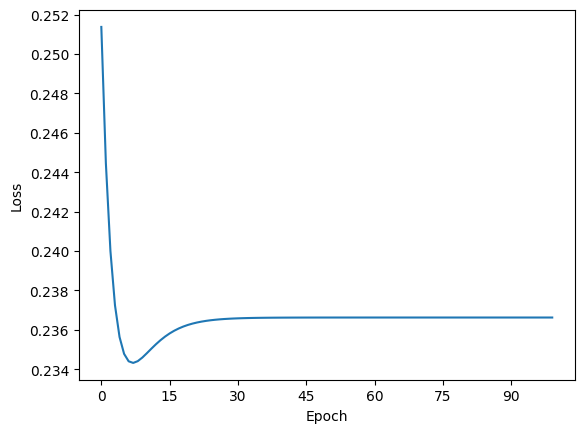

In [158]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import ticker

class EncoderLSTM:
    def __init__(self, input_dim, hidden_dim):
        self.lstm = LSTM(input_dim, hidden_dim, hidden_dim)
        
    def forward(self, x):
        _, h, c = self.lstm.forward(x)
        return h[:, -1], c[:, -1]

class DecoderLSTM:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.lstm = LSTM(input_dim, hidden_dim, output_dim)
        
    def forward(self, x, h, c):
        T = x.shape[1]
        output = np.zeros((self.lstm.output_dim, T))
        for t in range(T):
            y, h, c = self.lstm.forward(x[:, t:t+1])
            output[:, t] = y.flatten()
        return output, h, c

class Seq2SeqLSTM:
    def __init__(self, encoder, decoder):
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x_encoder, x_decoder):
        h, c = self.encoder.forward(x_encoder)
        output, _, _ = self.decoder.forward(x_decoder, h, c)
        return output

# 加载数据集
src_array, tgt_array, src_vocab, tgt_vocab, src_valid_len, tgt_valid_len = load_data_nmt(batch_size=2, num_steps=8)

# Hyperparameters
input_dim = len(src_vocab)
hidden_dim = 50
output_dim = len(target_vocab)

print("input_dim: {}\nhidden_dim: {}\noutput_dim: {}".format(input_dim, hidden_dim, output_dim))

# Initialize models
encoder_lstm = EncoderLSTM(input_dim, hidden_dim)
decoder_lstm = DecoderLSTM(output_dim, hidden_dim, output_dim)
seq2seq_lstm = Seq2SeqLSTM(encoder_lstm, decoder_lstm)

# Simple training loop (not using any framework, just for illustration)
learning_rate = 0.0001
num_epochs = 100

def cross_entropy_loss(output, target):
    m = target.shape[0]
    return -np.sum(np.log(output[np.arange(m), target])) / m

tot_loss = []
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    for src_seq, tgt_seq in zip(src_array, tgt_array):
        src_seq = np.eye(input_dim)[src_seq].T  # One-hot encoding
        tgt_seq_input = np.eye(output_dim)[tgt_seq[:-1]].T  # Exclude last token for input
        tgt_seq_target = tgt_seq[1:] # Exclude first token for target

        output = seq2seq_lstm.forward(src_seq, tgt_seq_input)

        output = np.exp(output) / np.sum(np.exp(output), axis=0)
        
        loss = cross_entropy_loss(output.T, tgt_seq_target)
        total_loss += loss
        
        # Backpropagation (gradient descent)
        # Simplified, normally you would need to implement backpropagation through time (BPTT)
        for param in [encoder_lstm.lstm.W_i, encoder_lstm.lstm.U_i, encoder_lstm.lstm.b_i,
                      encoder_lstm.lstm.W_f, encoder_lstm.lstm.U_f, encoder_lstm.lstm.b_f,
                      encoder_lstm.lstm.W_c, encoder_lstm.lstm.U_c, encoder_lstm.lstm.b_c,
                      encoder_lstm.lstm.W_o, encoder_lstm.lstm.U_o, encoder_lstm.lstm.b_o,
                      encoder_lstm.lstm.V, encoder_lstm.lstm.c,
                      decoder_lstm.lstm.W_i, decoder_lstm.lstm.U_i, decoder_lstm.lstm.b_i,
                      decoder_lstm.lstm.W_f, decoder_lstm.lstm.U_f, decoder_lstm.lstm.b_f,
                      decoder_lstm.lstm.W_c, decoder_lstm.lstm.U_c, decoder_lstm.lstm.b_c,
                      decoder_lstm.lstm.W_o, decoder_lstm.lstm.U_o, decoder_lstm.lstm.b_o,
                      decoder_lstm.lstm.V, decoder_lstm.lstm.c]:
            param -= learning_rate * param  # Simplified gradient descent update

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(raw_text)}")
    tot_loss.append(total_loss / len(raw_text))
print("训练完成")
_, ax = plt.subplots()
ax.plot(range(len(tot_loss)), tot_loss)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

In [ ]:
def translate(sentence, seq2seq, source_vocab, target_vocab, num_steps):
    # Convert sentence to indices
    src_seq = sentence.lower().split(' ')
    print(src_seq)
    for idx, word in enumerate(src_seq):
        src_seq[idx] = source_vocab[word]
    src_seq = truncate_pad(src_seq, num_steps, src_vocab['<pad>'])
    print(src_seq)
    src_seq = np.eye(input_dim)[src_seq].T  # One-hot encoding

    # Initialize decoder input with <PAD> tokens
    tgt_seq_input = np.zeros((output_dim, num_steps))
    tgt_seq_input[target_vocab['<PAD>'], :] = 1

    output = seq2seq.forward(src_seq, tgt_seq_input)
    
    # Convert output indices to words
    translated_sentence = []
    for idx in np.argmax(output, axis=0):
        translated_sentence.append(target_vocab.to_token(idx))

    return " ".join(translated_sentence)

# Example translation
test_sentence = "I am a student"
num_steps = 8
translation = translate(test_sentence, seq2seq_lstm, src_vocab, target_vocab, num_steps)
print(f"Translation: {translation}")

In [160]:
test_sentence = "I am a student"

source, target = tokenize_nmt(test_sentence)
print(src_vocab['<pad>'])

1
